# **1. Import necessary libraries**

In [ ]:
import os
import tweepy as tw
import pandas as pd
import csv
import pandas as pd
import glob
from nltk.corpus import stopwords
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras.models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import backend as K
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import namedtuple
import seaborn as sns
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **2. Necessary Data Cleaning Functions**

**Function to concatenate all csv files into one large corpus**

In [ ]:
def create_data_corpus(path):
  files = glob.glob(path + "/*.csv")
  df_list = []
  
  for file in files:
    df = pd.read_csv(file, index_col=None, header=0, engine='python')
    df_list.append(df)

  frame = pd.concat(df_list, axis=0, ignore_index=True)
  return frame

**Function to remove certain patterns in the data**

In [ ]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

**Function to carry out data cleaning**

In [ ]:
def clean_tweets(frame, column_name, remove_stop_words=True, lower_case=True, remove_special=True):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs

  if remove_special:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words
  if lower_case:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: x.lower())
  if remove_stop_words:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])) #remove stop words

  return frame

# **3. Preprocess the Dataset(Combined corpus of SemEval2017 + Airlines + subset of Sentiment140) for training the Networks**

In [ ]:
mega_frame = create_data_corpus('drive/My Drive/SentimentAnalysis/MegaData') #Use this path only (Modify if needed)
mega_frame = clean_tweets(frame=mega_frame, column_name='Column3', remove_stop_words=False, remove_special=False)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...
...,...,...,...,...
114213,2.192225e+09,positive,Hahaha! @futureguru100 that was just a work p...,hahaha! that was just a work project... he cou...
114214,2.191751e+09,positive,And the award for 'Longest Ever Interview' goe...,and the award for 'longest ever interview' goe...
114215,1.468895e+09,negative,Thinks!!!!!! i should have rented wheelman,thinks!!!!!! i should have rented wheelman
114216,1.469237e+09,negative,@MaryBethune I hate school right now! You are ...,i hate school right now! you are lucky you do...


In [ ]:
mega_frame['Column2'].value_counts()

positive    47028
negative    41842
neutral     25348
Name: Column2, dtype: int64

# **4. Build the Inputs to our networks**

**One-hot encode the labels**

In [ ]:
mega_frame["Sentiment_Value"] = mega_frame["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
labels = to_categorical(mega_frame["Sentiment_Value"], 3)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...,2
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...,0
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time,2
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...,2
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...,2
...,...,...,...,...,...
114213,2.192225e+09,positive,Hahaha! @futureguru100 that was just a work p...,hahaha! that was just a work project... he cou...,1
114214,2.191751e+09,positive,And the award for 'Longest Ever Interview' goe...,and the award for 'longest ever interview' goe...,1
114215,1.468895e+09,negative,Thinks!!!!!! i should have rented wheelman,thinks!!!!!! i should have rented wheelman,2
114216,1.469237e+09,negative,@MaryBethune I hate school right now! You are ...,i hate school right now! you are lucky you do...,2


**Get statistics of our data**

In [ ]:
mega_frame['test'] = mega_frame['Tweet_Clean_Text'].apply(lambda x: len(str(x).split()))
print("mean length of sentence: " + str(mega_frame.test.mean()))
print("max length of sentence: " + str(mega_frame.test.max()))
print("std dev length of sentence: " + str(mega_frame.test.std()))

mean length of sentence: 15.85478646097813
max length of sentence: 39
std dev length of sentence: 6.794046007912811


**Vectorize and convert text into sequences**

In [ ]:
maxlen = mega_frame.test.max()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(mega_frame['Tweet_Clean_Text'].values)
num_features = len(tokenizer.word_index) + 1
X = tokenizer.texts_to_sequences(mega_frame['Tweet_Clean_Text'].values)
X = pad_sequences(X, maxlen=maxlen, padding='post')

print("Vocab size: ", num_features)
print("Input shape: ", X.shape)
print("Labels shape: " , labels.shape)

Vocab size:  73456
Input shape:  (114218, 39)
Labels shape:  (114218, 3)


**Save the Tokenizer state for later use**

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Function to get GloVe embeddings**

In [ ]:
def get_w2v(path):
  file = open(path)
  w2v = {}
  for embedding_line in file:
    embedding_word = embedding_line.split()[0]
    embedding_value = np.asarray([float(value) for value in embedding_line.split()[1:]])
    w2v[embedding_word] = embedding_value
  return w2v

In [ ]:
glove_file_path = "drive/My Drive/SentimentAnalysis/GloVe/glove.twitter.27B.200d.txt"
w2v = get_w2v(glove_file_path)

In [ ]:
embedding_dim = 200
emb_mat = np.zeros((num_features, embedding_dim))
for word, i in tokenizer.word_index.items():
  vector = w2v.get(word)
  if vector is not None:
    emb_mat[i] = vector
  else:
    emb_mat[i] = np.random.randn(200)

**Create Training, Validation, and Test Data splits**

In [ ]:
#FINAL DATASETS (Please note case sensitivity)- TRAINING: (X_train,Y_train)  VALIDATION: (X_val, Y_val)  TEST: (X_test, Y_test)

Y = labels

x_train, X_test, y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 1)

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=1)

# **5. Build LSTM and CNN models**

## **Model helpers (metrics, callbacks, plots)**

### **Metrics**

In [ ]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1_metrics'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
]

### **Training Plots**

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 15, 10

def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

**Correlation Matrix**

In [ ]:
def correlation_matrix(models):
  train_predictions = []

  for model in models:
    train_predictions.append(model.predict([X_train], batch_size=1024))

  ndarray = np.array(train_predictions)
  positive = ndarray[:,:,0]
  neutral = ndarray[:,:,1]
  negative = ndarray[:,:,2]

  average = (np.corrcoef(positive) + np.corrcoef(neutral) + np.corrcoef(negative))/3

  sns.set_theme(style="white")

  mask = np.triu(np.ones_like(average, dtype=bool))

  f, ax = plt.subplots(figsize=(11,9))

  cmap = sns.diverging_palette(220,20, n=9, as_cmap=True)

  sns.heatmap(average, mask=mask, cmap=cmap, vmax=1, vmin=.75, center=.9,
              square=True, linewidth=.5, cbar_kws={"shrink":.5})

### **Callbacks**

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=1, verbose=1)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch > 9:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.h5".format(epoch))

saver = CustomSaver()

### **LSTM models**

## **LSTM Models**

**LSTM Model 1**

In [ ]:
def Build_LSTM_Model1():
  output_dims = 200
  lstm_out = 200
  dropout = 0.4
  recurrent_dropout = 0.4
  spatial_dropout_rate = 0.4
 
  model1 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.SpatialDropout1D(rate=spatial_dropout_rate),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
  
  return model1, model_info

**LSTM Model 2**

In [ ]:
def Build_LSTM_Model2():
  output_dims = 200
  lstm_out = 50
  dropout=0.6
  recurrent_dropout=0.6
  spatial_dropout_rate = 0.6
 
  model2 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.SpatialDropout1D(rate=spatial_dropout_rate),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dense(units=50, activation='relu'),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
 
  return model2, model_info

**LSTM Model 3**

In [ ]:
def Build_LSTM_Model3():
  output_dims = 200
  lstm_out = 100
  dropout=0.2
  recurrent_dropout=0.2
 
  model3 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dropout(rate=dropout),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
 
  return model3, model_info

**LSTM Model 4**

In [ ]:
def Build_LSTM_Model4():
  output_dims = 200
  lstm_out = 150
  dropout=0.3
  recurrent_dropout=0.3
 
  model4 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
  
  return model4, model_info

**LSTM Model 5**

In [ ]:
def Build_LSTM_Model5():
  output_dims = 200
  lstm_out = 250
  dropout=0.5
  recurrent_dropout=0.5
 
  model5 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
  
  return model5, model_info

## **CNN Models**

**Flat CNN Model 1**

In [ ]:
def Build_FlatCNN_Model1():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [2,3,4]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info


**FLAT CNN Model 2**

In [ ]:
def Build_FlatCNN_Model2():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [3,4,5]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info

**FLAT CNN Model 3**

In [ ]:
def Build_FlatCNN_Model3():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [5,6,7]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info

**FLAT CNN Model 4**

In [ ]:
def Build_FlatCNN_Model4():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [7,8,9]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info

**FLAT CNN Model 5**

In [ ]:
def Build_FlatCNN_Model5():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [9,10,11]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info

# **Train Models**

**Change directory to save models**

In [ ]:
os.chdir("/content/drive/MyDrive/SentimentAnalysis/Models")

**Model Generator**

In [ ]:
def model_gen(model_functions, metrics, callbacks):
  models =[]
  histories = []

  for model_fn in model_functions:
    model, model_info = model_fn()

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=model_info[1] + str(model_info[0]) + '.h5',
        save_weights_only=False,
        monitor='val_f1_metrics',
        mode='max',
        save_best_only=True,
        save_freq='epoch'
        )
    callbacks.append(model_checkpoint)

    model.compile(optimizer='adam',
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=metrics
                  )

    history = model.fit(X_train,
                        Y_train,
                        batch_size=3000,
                        epochs=20,
                        validation_data=(X_val,Y_val),
                        shuffle=True,
                        callbacks=callbacks
                        )
    
    models.append(model)
    histories.append(history)

  return models, histories

**Training LSTM**

In [ ]:
model_functions = [Build_LSTM_Model1, Build_LSTM_Model2, Build_LSTM_Model3, Build_LSTM_Model4, Build_LSTM_Model5]
callbacks = [early_stopping_callback, reduce_lr_callback]
lstm_models, lstm_histories = model_gen(model_functions=model_functions,metrics=metrics, callbacks=callbacks)

Epoch 1/20
31/31 [==============================] - 49s 1s/step - loss: 0.9989 - categorical_accuracy: 0.4823 - precision: 0.5745 - recall: 0.1900 - f1_metrics: 0.2522 - val_loss: 0.8032 - val_categorical_accuracy: 0.6311 - val_precision: 0.6599 - val_recall: 0.5807 - val_f1_metrics: 0.6193
Epoch 2/20
31/31 [==============================] - 38s 1s/step - loss: 0.8207 - categorical_accuracy: 0.6164 - precision: 0.6622 - recall: 0.5260 - f1_metrics: 0.5863 - val_loss: 0.7320 - val_categorical_accuracy: 0.6717 - val_precision: 0.6984 - val_recall: 0.6270 - val_f1_metrics: 0.6615
Epoch 3/20
31/31 [==============================] - 38s 1s/step - loss: 0.7663 - categorical_accuracy: 0.6516 - precision: 0.6929 - recall: 0.5741 - f1_metrics: 0.6279 - val_loss: 0.7037 - val_categorical_accuracy: 0.6861 - val_precision: 0.7133 - val_recall: 0.6511 - val_f1_metrics: 0.6814
Epoch 4/20
31/31 [==============================] - 38s 1s/step - loss: 0.7338 - categorical_accuracy: 0.6687 - precision: 0

In [ ]:
best_indiv = 0.0
for history in lstm_histories:
  best_indiv = max(best_indiv, max(history.history['val_f1_metrics']))
print("Best individual F1 = {}".format(best_indiv))

Best individual F1 = 0.7292219400405884


In [ ]:
for i, lstm_model in enumerate(lstm_models):
  print("\nLSTM_Model_{0}".format(i+1))
  lstm_model.evaluate(X_test, Y_test, batch_size=1000)


LSTM_Model_1
12/12 [==============================] - 1s 111ms/step - loss: 0.6476 - categorical_accuracy: 0.7247 - precision: 0.7409 - recall: 0.7043 - f1_metrics: 0.7224

LSTM_Model_2
12/12 [==============================] - 1s 64ms/step - loss: 0.6984 - categorical_accuracy: 0.7048 - precision: 0.7211 - recall: 0.6825 - f1_metrics: 0.7014

LSTM_Model_3
12/12 [==============================] - 1s 72ms/step - loss: 0.6684 - categorical_accuracy: 0.7150 - precision: 0.7317 - recall: 0.6918 - f1_metrics: 0.7110

LSTM_Model_4
12/12 [==============================] - 1s 87ms/step - loss: 0.6659 - categorical_accuracy: 0.7134 - precision: 0.7297 - recall: 0.6917 - f1_metrics: 0.7097

LSTM_Model_5
12/12 [==============================] - 1s 117ms/step - loss: 0.6621 - categorical_accuracy: 0.7191 - precision: 0.7339 - recall: 0.6946 - f1_metrics: 0.7132


**LSTM Models Training Plots**

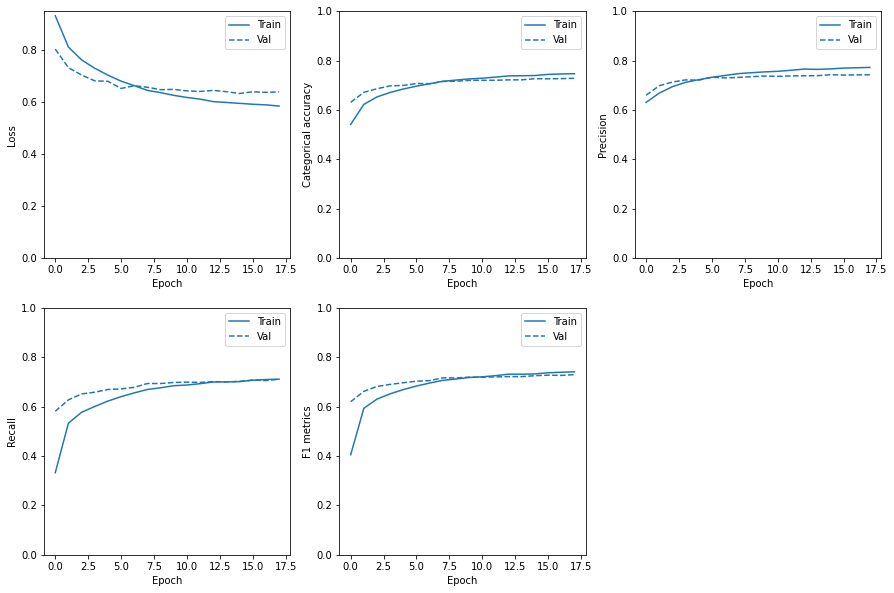

In [ ]:
plot_metrics(lstm_histories[0])

**Correlation Matrix for LSTM**

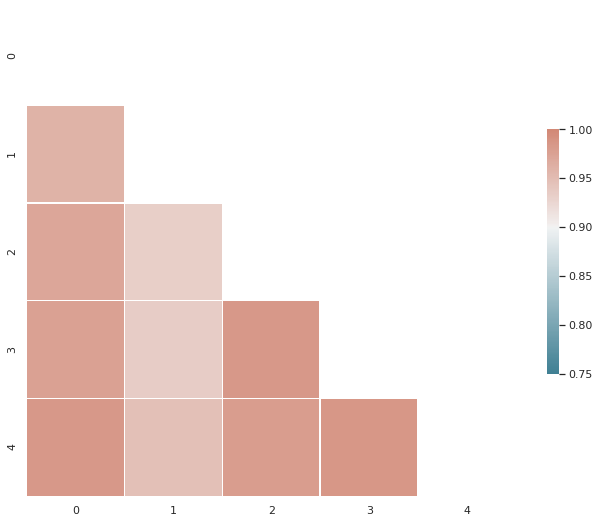

In [ ]:
correlation_matrix(lstm_models)

**Training CNN**

In [ ]:
model_functions = [Build_FlatCNN_Model1, Build_FlatCNN_Model2, Build_FlatCNN_Model3, Build_FlatCNN_Model4, Build_FlatCNN_Model5]
callbacks = [early_stopping_callback, reduce_lr_callback]
flat_cnn_models, flat_cnn_histories = model_gen(model_functions=model_functions,metrics=metrics, callbacks=callbacks)

Epoch 1/20
31/31 [==============================] - 38s 303ms/step - loss: 1.0581 - categorical_accuracy: 0.5023 - precision: 0.6755 - recall: 0.2090 - f1_metrics: 0.0726 - val_loss: 0.9546 - val_categorical_accuracy: 0.5481 - val_precision: 0.6906 - val_recall: 0.1972 - val_f1_metrics: 0.3071
Epoch 2/20
31/31 [==============================] - 8s 273ms/step - loss: 0.9334 - categorical_accuracy: 0.5459 - precision: 0.6368 - recall: 0.2866 - f1_metrics: 0.3923 - val_loss: 0.8590 - val_categorical_accuracy: 0.6027 - val_precision: 0.6855 - val_recall: 0.4384 - val_f1_metrics: 0.5358
Epoch 3/20
31/31 [==============================] - 9s 284ms/step - loss: 0.8366 - categorical_accuracy: 0.6148 - precision: 0.6784 - recall: 0.4683 - f1_metrics: 0.5539 - val_loss: 0.8073 - val_categorical_accuracy: 0.6276 - val_precision: 0.6781 - val_recall: 0.5342 - val_f1_metrics: 0.5983
Epoch 4/20
31/31 [==============================] - 9s 293ms/step - loss: 0.7656 - categorical_accuracy: 0.6554 - pre

**Get best individual F1**

In [ ]:
best_indiv = 0.0
for history in flat_cnn_histories:
  best_indiv = max(best_indiv, max(history.history['val_f1_metrics']))
print("Best individual F1 = {}".format(best_indiv))

Best individual F1 = 0.6749107837677002


**Evalute FLAT CNN on Test Data**

In [ ]:
for i, flat_cnn_model in enumerate(flat_cnn_models):
  print("\nFlat_CNN_Model_{0}".format(i+1))
  flat_cnn_model.evaluate(X_test, Y_test, batch_size=1000)


Flat_CNN_Model_1
12/12 [==============================] - 1s 55ms/step - loss: 0.8371 - categorical_accuracy: 0.6585 - precision: 0.6744 - recall: 0.6342 - f1_metrics: 0.6535

Flat_CNN_Model_2
12/12 [==============================] - 0s 31ms/step - loss: 0.7859 - categorical_accuracy: 0.6651 - precision: 0.6860 - recall: 0.6309 - f1_metrics: 0.6566

Flat_CNN_Model_3
12/12 [==============================] - 1s 47ms/step - loss: 0.7984 - categorical_accuracy: 0.6726 - precision: 0.6900 - recall: 0.6468 - f1_metrics: 0.6670

Flat_CNN_Model_4
12/12 [==============================] - 1s 48ms/step - loss: 0.7777 - categorical_accuracy: 0.6701 - precision: 0.6887 - recall: 0.6397 - f1_metrics: 0.6639

Flat_CNN_Model_5
12/12 [==============================] - 1s 50ms/step - loss: 0.8079 - categorical_accuracy: 0.6677 - precision: 0.6834 - recall: 0.6387 - f1_metrics: 0.6601


**FLAT CNN Models Training Plots**

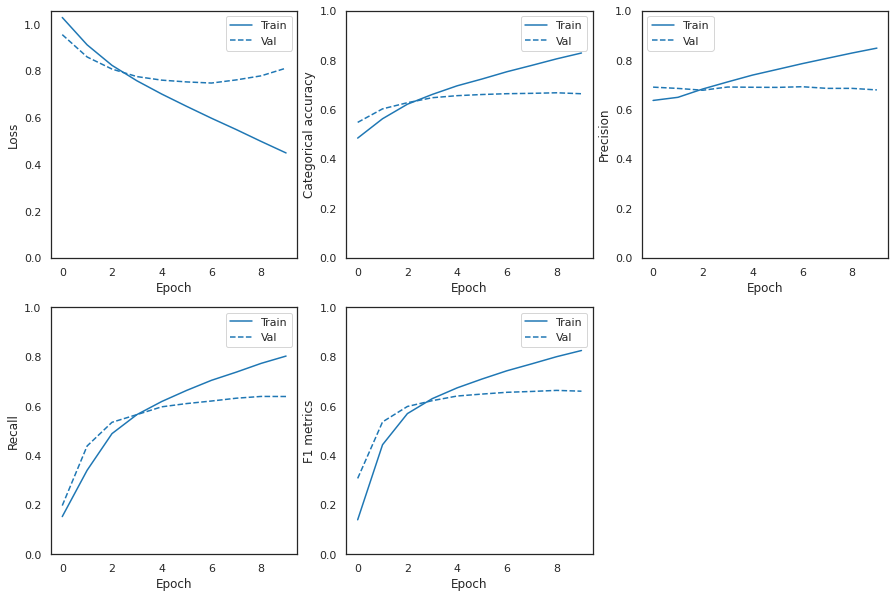

In [ ]:
plot_metrics(flat_cnn_histories[0])

**Correlation Matrix for Flat CNN**

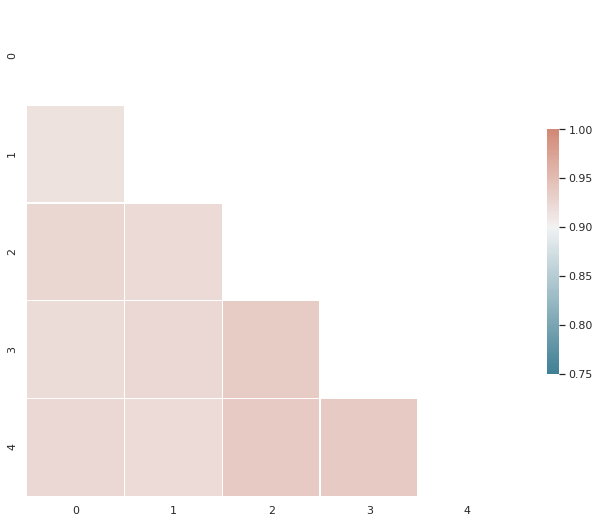

In [ ]:
correlation_matrix(flat_cnn_models)